In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [4]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=range(2006, 2021),
    time_group='12h',
    price_calculation='close',
)

In [5]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [6]:
price_data = add_features(price_data.copy())

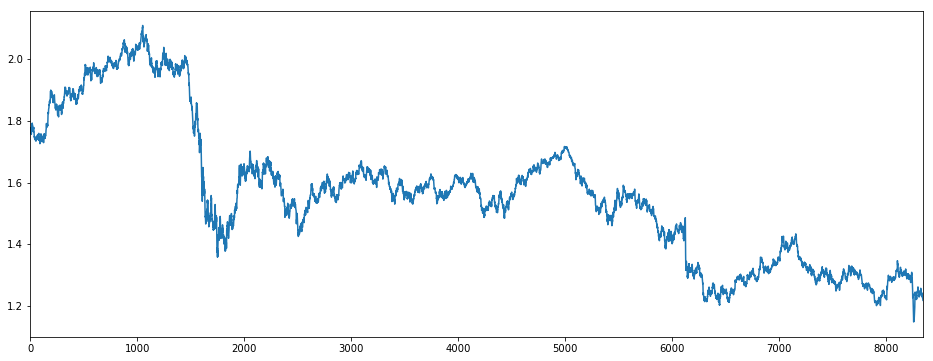

In [7]:
price_data['price'].plot(figsize=(16,6))

In [9]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 5562, test size 2781


In [10]:
episode=1000
batch_size=10

In [11]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-12 12:00:00,1.76080,1.77135,1.75800,1.76825,1.76080,0.494794,0.010280,0.317634
1,1,2006-01-13 00:00:00,1.76665,1.77165,1.75960,1.76080,1.76665,0.500048,0.010723,0.307017
2,2,2006-01-13 12:00:00,1.77740,1.77845,1.76485,1.76665,1.77740,0.606954,0.011444,0.302499
3,3,2006-01-15 12:00:00,1.77780,1.77900,1.77460,1.77460,1.77780,0.614644,0.009680,0.283419
4,4,2006-01-16 00:00:00,1.76935,1.77970,1.76885,1.77780,1.76935,0.497277,0.009973,0.299910


In [12]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [13]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: 4354 pips, median trade count: 665
....................
episode: 40/1000
median profit: 3826 pips, median trade count: 614
....................
episode: 60/1000
median profit: 3826 pips, median trade count: 614
....................
episode: 80/1000
median profit: 4377 pips, median trade count: 563
....................
episode: 100/1000
median profit: 5604 pips, median trade count: 570
....................
episode: 120/1000
median profit: 6651 pips, median trade count: 588
....................
episode: 140/1000
median profit: 6754 pips, median trade count: 563
....................
episode: 160/1000
median profit: 6750 pips, median trade count: 558
.........

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


...........
episode: 180/1000
median profit: 6566 pips, median trade count: 552
....................
episode: 200/1000
median profit: 6566 pips, median trade count: 502
....................
episode: 220/1000
median profit: 6381 pips, median trade count: 468
...............

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


.....
episode: 240/1000
median profit: 6529 pips, median trade count: 445
....................
episode: 260/1000
median profit: 6615 pips, median trade count: 440
....................
episode: 280/1000
median profit: 6637 pips, median trade count: 438
....................
episode: 300/1000
median profit: 6605 pips, median trade count: 430
....................
episode: 320/1000
median profit: 6615 pips, median trade count: 426
....................
episode: 340/1000
median profit: 6623 pips, median trade count: 414
....................
episode: 360/1000
median profit: 6679 pips, median trade count: 414
....................
episode: 380/1000
median profit: 6651 pips, median trade count: 411
....................
episode: 400/1000
median profit: 6684 pips, median trade count: 406
....................
episode: 420/1000
median profit: 6754 pips, median trade count: 401
....................
episode: 440/1000
median profit: 6862 pips, median trade count: 396
....................
episode: 460/10

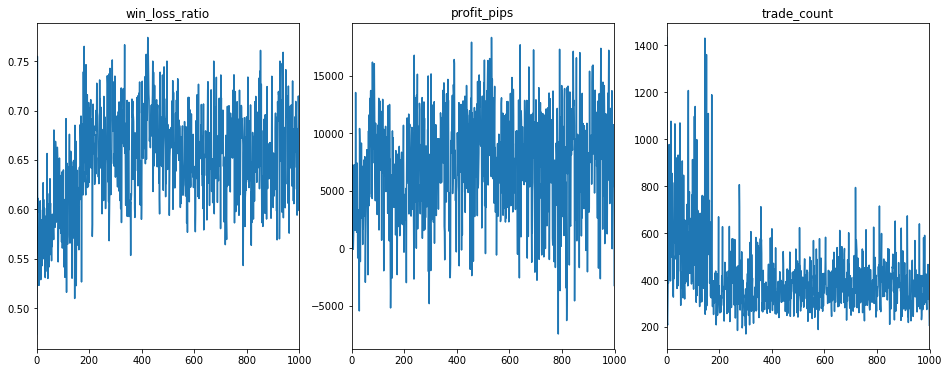

In [14]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [15]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['12h-GBP_USD.pkl']

## Test

In [16]:
# Uncomment to load agent from file 
agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [17]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [18]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [19]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
test_results['account_drawdown_max_pips'] = test_results['account_drawdown_max'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))
print('Median drawdown: {0} pips'.format(test_results['account_drawdown_max_pips'].median()))

Median profit: 2818.1999999999152 pips
Median drawdown: -1875.5250000000156 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137d6d850>]],
      dtype=object)

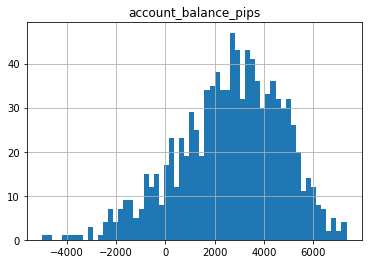

In [20]:
# Historgram of account balance
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137464410>]],
      dtype=object)

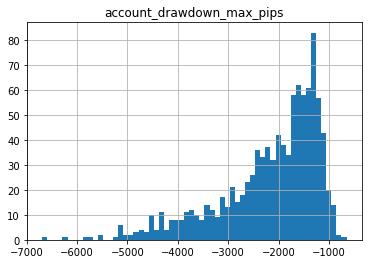

In [21]:
# Historgram of max drawdown
plt.figure(figsize=(16,6))
test_results.hist(column='account_drawdown_max_pips', bins=60)

## Analyse positions on test data

In [44]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [45]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [46]:
env._stats()

{'trade_count': 139,
 'win_loss_ratio': 0.7410071942446043,
 'account_balance': 0.5561049999999912,
 'unrealised_pl': -0.015784999999999938,
 'account_drawdown': 0.0,
 'account_drawdown_max': -0.11216000000000093}

In [47]:
position_data = env.price_data.copy()

In [48]:
position_data['position'] = position_data['position'] - 1

In [49]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

141 positions to plot...


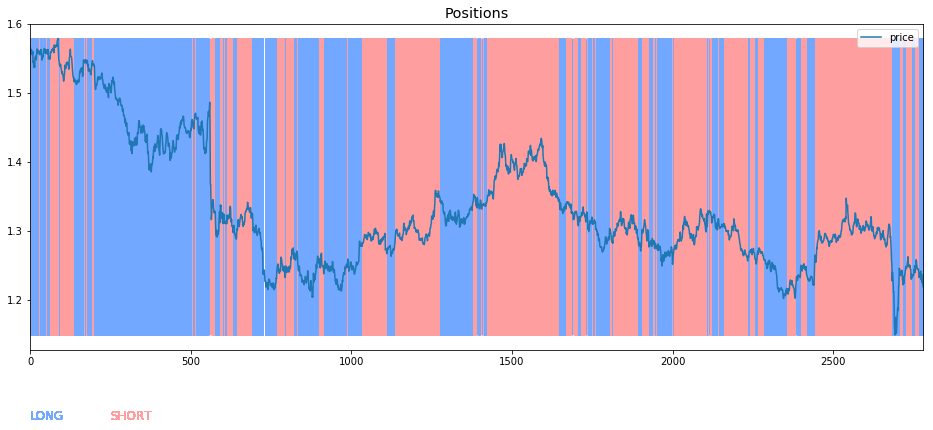

In [50]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [51]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 73.76%
Ratio of long to short positions: 1.0
Median profit: 0.0
Total profit: 0.5508199999999979
Median position length: 7.0
Number of trades: 141


In [52]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2015-07-01 00:00:00,1.56557,2015-07-01 12:00:00,1.56034,1,NaN,NaN,False,NaN
1,2015-07-01 12:00:00,1.56034,2015-07-17 12:00:00,1.56010,26,1.0,-0.00024,False,-0.00024
2,2015-07-17 12:00:00,1.56010,2015-07-20 00:00:00,1.55535,2,-1.0,0.00475,True,0.00451
3,2015-07-20 00:00:00,1.55535,2015-08-02 12:00:00,1.56219,21,1.0,0.00684,True,0.01135
4,2015-08-02 12:00:00,1.56219,2015-08-03 12:00:00,1.55892,2,-1.0,0.00327,True,0.01462
...,...,...,...,...,...,...,...,...,...
136,2020-04-03 12:00:00,1.22703,2020-04-09 12:00:00,1.24548,9,1.0,0.01845,True,0.53631
137,2020-04-09 12:00:00,1.24548,2020-04-21 12:00:00,1.23014,18,-1.0,0.01534,True,0.55165
138,2020-04-22 00:00:00,1.23720,2020-04-28 12:00:00,1.24344,10,1.0,0.00624,True,0.55789
139,2020-04-28 12:00:00,1.24344,2020-05-07 00:00:00,1.23480,14,-1.0,0.00864,True,0.56653


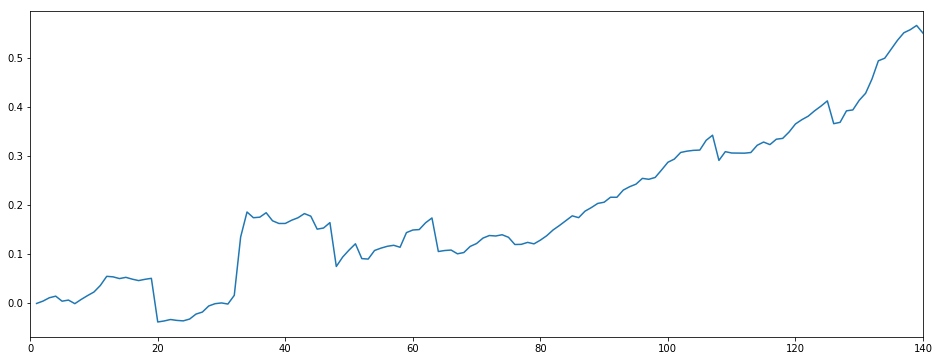

In [53]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.13478000000000023


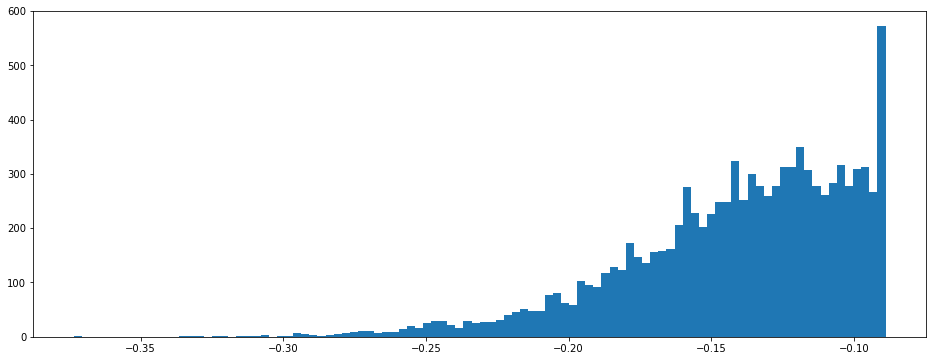

In [54]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);